In [48]:
import torch
import torchvision
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import cv2
from sklearn.model_selection import train_test_split

import os
from glob import glob
import requests
import random
import sys
from time import time
from enum import Enum

In [2]:
data_dir = '/opt/ml/input/data/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/train.csv'

In [3]:
df = pd.read_csv(df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [4]:
def get_ext(img_dir, img_id):
    # img_id: 하위 폴더 이름

    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()

    return ext

In [5]:
def get_img_stats(img_dir, img_ids):

    img_info = dict(heights=[], widths=[], means=[], stds=[])

    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            # img_dir: /opt/ml/input/data/train/images
            # img_id: 000001_female_Asian_45
            # path: /opt/ml/input/data/train/images/000001_female_Asian_45/normal.jpg
            #       /opt/ml/input/data/train/images/000001_female_Asian_45/mask1.jpg
            #       /opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg
            #       ...

            img = np.array(Image.open(path))
            h, w, c = img.shape
            # img.shape: (512, 384, 3)

            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))

    return img_info

In [6]:
img_info = get_img_stats(img_dir, df.path.values)

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')


RGB Mean: [0.56019358 0.52410121 0.501457  ]
RGB Standard Deviation: [0.23318603 0.24300033 0.24567522]


In [41]:
mean = (0.56019358, 0.52410121, 0.501457)
std = (0.23318603, 0.24300033, 0.24567522)

### torchvision transforms

In [9]:
from torchvision.transforms import Resize, ToTensor, Normalize, GaussianBlur, RandomRotation, ColorJitter

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size())*self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

def get_transforms(need=('train', 'val'), img_size=(512, 384)):

    transformations = {}

    if 'train' in need:
        transformations['train'] = torchvision.transforms.Compose([
            Resize((img_size[0], img_size[1])),
            RandomRotation([-8, +8]),
            GaussianBlur(51, (0.1, 2.0)),
            ColorJitter(brightness=0.5, saturation=0.5, hue=0.5),
            ToTensor(),
            Normalize(mean=mean, std=std),
            AddGaussianNoise(0., 1.)
        ])

    if 'val' in need:
        transformations['val'] = torchvision.transforms.Compose([
            Resize((img_size[0], img_size[1])),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])

    return transformations

### albumentations transform

In [43]:
from albumentations import *
from albumentations.pytorch import ToTensorV2

def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):

    transformations = {}
    
    if 'train' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
        
    return transformations

# Dataset

In [10]:
class MaskLabels(int, Enum):
    MASK = 0
    INCORRECT = 1
    NORMAL = 2

class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:

        value = value.lower()

        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")

class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD

In [39]:
class MaskBaseDataset(torch.utils.data.Dataset):
    num_classes = 3 * 2 * 3

    file_names_list = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, img_dir, mean, std, transform=None):

        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform

        self.setup()

    def set_transform(self, transform):
        self.transform = transform
        
    def setup(self):

        profiles = os.listdir(self.img_dir) # os.listdir: returns the list of all files and directories in the specified directory
        for profile in profiles: # profile: 이미지 7개가 담긴 폴더
            if profile.startswith("."):
                continue

            img_folder = os.path.join(self.img_dir, profile)
            for file_name in os.listdir(img_folder):
                file_name_without_ext, ext = os.path.splitext(file_name)
                if file_name_without_ext not in self.file_names_list:
                    continue

                img_path = os.path.join(self.img_dir, profile, file_name)
                self.image_paths.append(img_path)

                mask_label = self.file_names_list[file_name_without_ext]
                self.mask_labels.append(mask_label)

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def __getitem__(self, index):

        image_path = self.image_paths[index]
        image = Image.open(image_path) # PIL image
        image = np.array(image) # numpy ndarray
        image_transform = self.transform(image=image)['image']
        
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label
        
        return image_transform, multi_class_label

    def __len__(self):
        return len(self.image_paths)

In [37]:
profiles = os.listdir(img_dir)
print(len(profiles)) # '.'으로 시작하는 폴더명 포함
print(profiles[0])

5400
003566_male_Asian_53


<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG


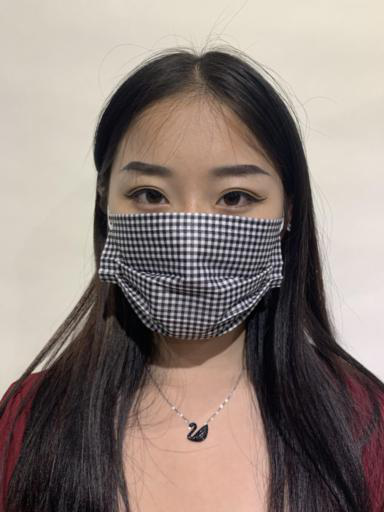

In [38]:
image_path = f'{data_dir}/images/006355_female_Asian_18/mask5.jpg'
image = Image.open(image_path)

print(type(image))
print(image.format)
# image.show()
image

<class 'numpy.ndarray'>


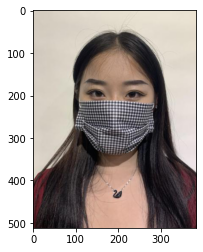

In [36]:
image = np.array(image)

print(type(image))
plt.imshow(image)

In [44]:
transform = get_transforms(mean=mean, std=std)

dataset = MaskBaseDataset(img_dir=img_dir, mean=mean, std=std)

n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

# DataLoader

In [45]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=False
)

# Visualize processed data

In [46]:
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([12, 3, 512, 384])
labels shape: torch.Size([12])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


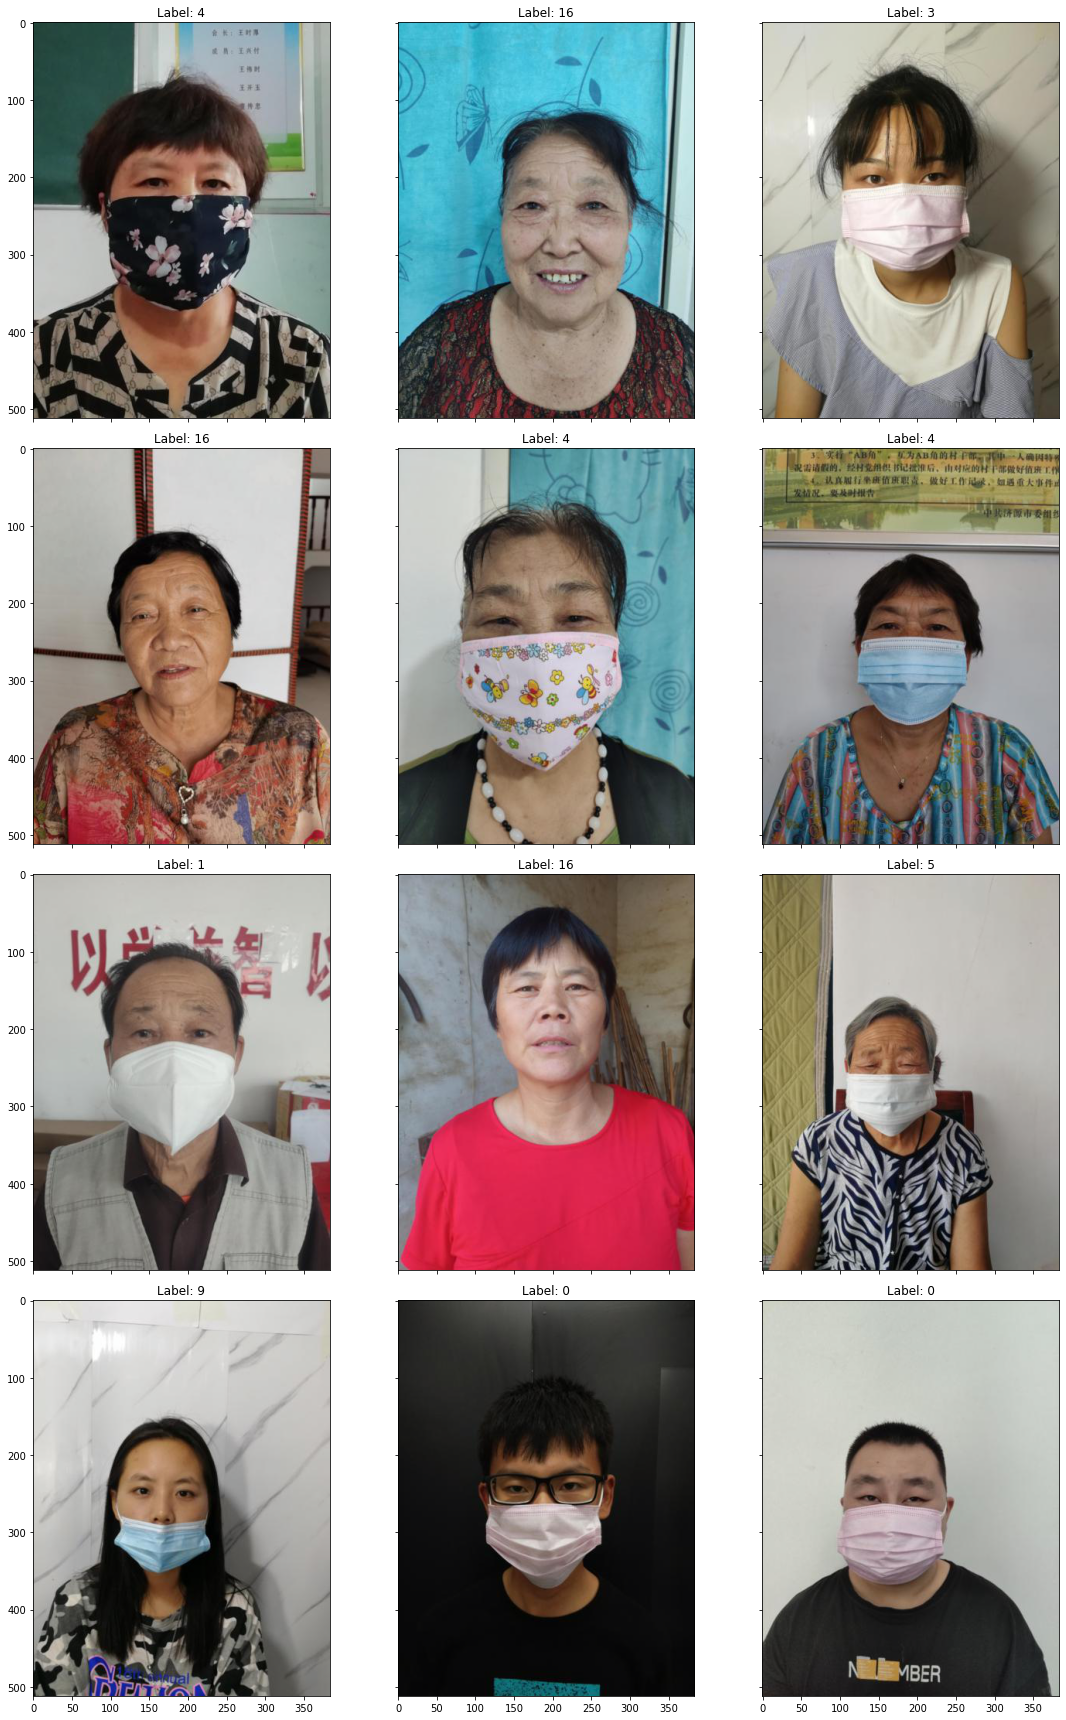

In [50]:
inverse_normalize = torchvision.transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))

for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols+1)].imshow(inverse_normalize(images[i]).permute(1, 2, 0))
    axes[i%n_rows][i//(n_cols+1)].set_title(f'Label: {labels[i]}')

plt.tight_layout()